# LSTM Poker Agent V2 - Fixed DRQN Architecture

This notebook implements a **Deep Recurrent Q-Network (DRQN)** agent for No-Limit Texas Hold'em.

## Key Fixes from V1:
1. **LSTM processes full state sequence** (not just action tokens) - proper DRQN
2. **Batched training** - processes episodes together with padding
3. **Track all actions** - both player and opponent
4. **Intermediate reward shaping** - helps with credit assignment

In [1]:
# Cell 1: Dependencies & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Any

from pokerkit import Automation, NoLimitTexasHoldem, Card

# Constants
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Action Space

# Environment action space
ENV_FOLD = 0
ENV_CHECK_CALL = 1
ENV_BET_RAISE = 2
NUM_ACTIONS = 3

In [3]:
# Cell 3: Custom Gym Wrapper for PokerKit

class PokerKitGymEnv(gym.Env):
    """Gymnasium wrapper for PokerKit's No-Limit Texas Hold'em."""
    
    def __init__(self, num_players: int = 2, starting_stack: int = 200, 
                 small_blind: int = 1, big_blind: int = 2):
        super().__init__()
        
        self.num_players = num_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        
        # State: 2 hole cards (52*2) + 5 board (52*5) + stacks + pot + position + street
        self.game_state_dim = 52*2 + 52*5 + num_players + 1 + 1 + 4  # 372
        
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.game_state_dim,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        
        self.state = None
        self.agent_player_index = 0
        
    def _card_to_index(self, card: Card) -> int:
        ranks = '23456789TJQKA'
        suits = 'cdhs'
        rank_idx = ranks.index(card.rank)
        suit_idx = suits.index(card.suit)
        return rank_idx * 4 + suit_idx
    
    def _encode_card(self, card: Optional[Card]) -> np.ndarray:
        encoding = np.zeros(52, dtype=np.float32)
        if card is not None:
            encoding[self._card_to_index(card)] = 1.0
        return encoding
    
    def _flatten_cards(self, cards) -> List:
        flat = []
        for item in cards:
            if hasattr(item, 'rank'):
                flat.append(item)
            else:
                flat.extend(self._flatten_cards(item))
        return flat
    
    def _get_game_state(self) -> np.ndarray:
        """Get the full game state as a flat vector."""
        state_vector = []
        
        # Hole cards (104 dims)
        hole_cards = self._flatten_cards(self.state.hole_cards[self.agent_player_index])
        for i in range(2):
            if i < len(hole_cards):
                state_vector.extend(self._encode_card(hole_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        # Board cards (260 dims)
        board_cards = self._flatten_cards(self.state.board_cards)
        for i in range(5):
            if i < len(board_cards):
                state_vector.extend(self._encode_card(board_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        # Stack sizes (normalized)
        for i in range(self.num_players):
            stack = self.state.stacks[i] / self.starting_stack
            state_vector.append(min(stack, 2.0))
        
        # Pot size (normalized)
        total_pot = sum(self.state.bets)
        state_vector.append(total_pot / (self.starting_stack * self.num_players))
        
        # Position indicator
        if self.state.actor_index is not None:
            state_vector.append(self.state.actor_index / max(1, self.num_players - 1))
        else:
            state_vector.append(0.0)
        
        # Street indicator (one-hot)
        street = [0.0, 0.0, 0.0, 0.0]
        num_board = len(board_cards)
        if num_board == 0:
            street[0] = 1.0  # Preflop
        elif num_board == 3:
            street[1] = 1.0  # Flop
        elif num_board == 4:
            street[2] = 1.0  # Turn
        else:
            street[3] = 1.0  # River
        state_vector.extend(street)
        
        return np.array(state_vector, dtype=np.float32)
    
    def _get_legal_actions(self) -> List[int]:
        legal = []
        if self.state.can_fold():
            legal.append(ENV_FOLD)
        if self.state.can_check_or_call():
            legal.append(ENV_CHECK_CALL)
        if self.state.can_complete_bet_or_raise_to():
            legal.append(ENV_BET_RAISE)
        return legal if legal else [ENV_CHECK_CALL]
    
    def _execute_action(self, action: int) -> None:
        if action == ENV_FOLD:
            if self.state.can_fold():
                self.state.fold()
            elif self.state.can_check_or_call():
                self.state.check_or_call()
        elif action == ENV_CHECK_CALL:
            if self.state.can_check_or_call():
                self.state.check_or_call()
            elif self.state.can_fold():
                self.state.fold()
        elif action == ENV_BET_RAISE:
            if self.state.can_complete_bet_or_raise_to():
                min_raise = self.state.min_completion_betting_or_raising_to_amount
                max_raise = self.state.max_completion_betting_or_raising_to_amount
                # Bet pot-sized or min, whichever is larger
                pot = sum(self.state.bets)
                raise_amount = max(min_raise, min(pot, max_raise))
                self.state.complete_bet_or_raise_to(raise_amount)
            elif self.state.can_check_or_call():
                self.state.check_or_call()
    
    def _run_automations(self) -> None:
        while self.state.can_burn_card():
            self.state.burn_card('??')
        while self.state.can_deal_board():
            self.state.deal_board()
        while self.state.can_push_chips():
            self.state.push_chips()
        while self.state.can_pull_chips():
            self.state.pull_chips()
    
    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        
        self.state = NoLimitTexasHoldem.create_state(
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING,
            ),
            ante_trimming_status=True,
            raw_antes={-1: 0},
            raw_blinds_or_straddles=(self.small_blind, self.big_blind),
            min_bet=self.big_blind,
            raw_starting_stacks=[self.starting_stack] * self.num_players,
            player_count=self.num_players,
        )
        
        while self.state.can_deal_hole():
            self.state.deal_hole()
        
        self._run_automations()
        
        return self._get_game_state(), {'legal_actions': self._get_legal_actions()}
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        self._execute_action(action)
        self._run_automations()
        
        done = self.state.status is False
        
        reward = 0.0
        if done:
            final_stack = self.state.stacks[self.agent_player_index]
            reward = (final_stack - self.starting_stack) / self.big_blind
        
        obs = self._get_game_state()
        info = {
            'legal_actions': self._get_legal_actions() if not done else [],
            'current_player': self.state.actor_index if not done else None
        }
        
        return obs, reward, done, False, info
    
    def get_current_player(self) -> Optional[int]:
        if self.state.status is False:
            return None
        return self.state.actor_index

In [4]:
# Cell 4: Sequence Replay Buffer (stores full episodes)

class SequenceReplayBuffer:
    """Replay buffer that stores full episodes for DRQN training."""
    
    def __init__(self, capacity: int = 5000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, episode: List[Tuple]):
        """Store a complete episode: [(state, action, reward, next_state, done, legal_actions), ...]"""
        if len(episode) > 0:
            self.buffer.append(episode)
    
    def sample(self, batch_size: int):
        """Sample a batch of episodes."""
        batch = random.sample(list(self.buffer), min(batch_size, len(self.buffer)))
        return batch
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# Cell 5: FIXED DRQN Model - LSTM processes full state sequence

class DRQN(nn.Module):
    """
    Deep Recurrent Q-Network.
    
    KEY FIX: LSTM processes the FULL STATE SEQUENCE, not just action tokens.
    This allows the network to learn temporal patterns in the game state.
    """
    
    def __init__(self, input_dim: int, hidden_dim: int = 128, 
                 output_dim: int = NUM_ACTIONS, num_layers: int = 1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Feature extractor: processes raw state into features
        self.fc_feat = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        # LSTM: processes sequence of feature vectors
        # This is the KEY difference - we process STATE sequence, not action tokens
        self.lstm = nn.LSTM(
            input_size=128, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True
        )
        
        # Q-value head
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x: torch.Tensor, hidden: Optional[Tuple] = None):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, seq_len, input_dim)
            hidden: Optional LSTM hidden state
        
        Returns:
            q_values: Q-values for each action at each timestep (batch, seq_len, num_actions)
            new_hidden: Updated LSTM hidden state
        """
        batch_size, seq_len, _ = x.size()
        
        # Process features for every timestep
        x_flat = x.view(-1, x.size(2))  # (batch*seq, input_dim)
        features = self.fc_feat(x_flat)  # (batch*seq, 128)
        features = features.view(batch_size, seq_len, -1)  # (batch, seq, 128)
        
        # Pass through LSTM
        if hidden is None:
            lstm_out, new_hidden = self.lstm(features)
        else:
            lstm_out, new_hidden = self.lstm(features, hidden)
        
        # Calculate Q-values for each timestep
        q_values = self.fc_out(lstm_out)  # (batch, seq, num_actions)
        
        return q_values, new_hidden
    
    def init_hidden(self, batch_size: int):
        """Initialize LSTM hidden state."""
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h, c)

In [6]:
# Cell 6: Fixed-Strategy Opponents

class ManiacAgent:
    """Always raises/bets when possible, otherwise calls."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        if ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class NitAgent:
    """Always folds when facing aggression, checks otherwise."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        # If facing a bet (fold is an option alongside call), usually fold
        if ENV_FOLD in legal_actions and ENV_CHECK_CALL in legal_actions:
            if random.random() < 0.9:  # 90% fold rate vs bets
                return ENV_FOLD
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class RandomAgent:
    """Randomly selects from legal actions."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        return random.choice(legal_actions)

In [7]:
# Cell 7: DRQN Agent with Proper Batched Training

class DRQNAgent:
    """
    DRQN Agent with epsilon-greedy exploration and proper batched training.
    """
    
    def __init__(self, input_dim: int, hidden_dim: int = 128,
                 lr: float = 1e-3, gamma: float = 0.99,
                 epsilon_start: float = 1.0, epsilon_min: float = 0.05,
                 epsilon_decay: float = 0.9995):
        
        self.input_dim = input_dim
        self.model = DRQN(input_dim, hidden_dim).to(device)
        self.target_model = DRQN(input_dim, hidden_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Track hidden state for inference
        self.current_hidden = None
    
    def reset_hidden(self):
        """Reset LSTM hidden state at start of episode."""
        self.current_hidden = None
    
    def select_action(self, state: np.ndarray, legal_actions: List[int], 
                      eval_mode: bool = False) -> int:
        """Select action with epsilon-greedy policy."""
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)
        
        # Convert state to tensor: (1, 1, input_dim)
        state_t = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q_values, self.current_hidden = self.model(state_t, self.current_hidden)
        
        # Mask illegal actions
        q_values = q_values[0, 0].cpu().numpy()
        masked_q = np.full(NUM_ACTIONS, -np.inf)
        for a in legal_actions:
            masked_q[a] = q_values[a]
        
        return int(np.argmax(masked_q))
    
    def update_epsilon(self):
        """Decay epsilon."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def update_target_network(self):
        """Copy weights to target network."""
        self.target_model.load_state_dict(self.model.state_dict())
    
    def train_step(self, buffer: SequenceReplayBuffer, batch_size: int = 32) -> Optional[float]:
        """
        Train on a batch of episodes with PROPER BATCHING.
        
        Key improvement: processes entire sequences at once instead of transition-by-transition.
        """
        if len(buffer) < batch_size:
            return None
        
        batch = buffer.sample(batch_size)
        
        # Sort by length for efficient processing
        batch.sort(key=lambda x: len(x), reverse=True)
        
        lengths = [len(ep) for ep in batch]
        max_len = max(lengths)
        
        # Pad sequences
        states_padded = torch.zeros(batch_size, max_len, self.input_dim).to(device)
        actions_padded = torch.zeros(batch_size, max_len, dtype=torch.long).to(device)
        rewards_padded = torch.zeros(batch_size, max_len).to(device)
        next_states_padded = torch.zeros(batch_size, max_len, self.input_dim).to(device)
        dones_padded = torch.zeros(batch_size, max_len).to(device)
        legal_mask = torch.zeros(batch_size, max_len, NUM_ACTIONS).to(device)
        
        for i, episode in enumerate(batch):
            for t, (s, a, r, ns, d, la) in enumerate(episode):
                states_padded[i, t] = torch.FloatTensor(s)
                actions_padded[i, t] = a
                rewards_padded[i, t] = r
                next_states_padded[i, t] = torch.FloatTensor(ns)
                dones_padded[i, t] = float(d)
                for action_idx in la:
                    if action_idx < NUM_ACTIONS:
                        legal_mask[i, t, action_idx] = 1.0
        
        # Forward pass on current states
        q_values, _ = self.model(states_padded)
        q_pred = q_values.gather(2, actions_padded.unsqueeze(2)).squeeze(2)
        
        # Forward pass on next states for target
        with torch.no_grad():
            target_q_values, _ = self.target_model(next_states_padded)
            max_target_q, _ = target_q_values.max(dim=2)
        
        # Calculate targets
        targets = rewards_padded + self.gamma * max_target_q * (1 - dones_padded)
        
        # Create mask for valid timesteps (not padding)
        seq_mask = torch.zeros(batch_size, max_len).to(device)
        for i, length in enumerate(lengths):
            seq_mask[i, :length] = 1.0
        
        # Masked MSE loss
        loss = F.mse_loss(q_pred, targets, reduction='none')
        loss = (loss * seq_mask).sum() / seq_mask.sum()
        
        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()

In [8]:
# Cell 8: Training Loop

def train_agent(num_episodes: int = 2000, batch_size: int = 32, 
                target_update_freq: int = 100, eval_freq: int = 100):
    """
    Train the DRQN agent.
    
    Trains first half against Maniac, second half against Nit.
    """
    env = PokerKitGymEnv(num_players=2, starting_stack=200, small_blind=1, big_blind=2)
    agent = DRQNAgent(input_dim=env.game_state_dim)
    buffer = SequenceReplayBuffer(capacity=5000)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    
    rewards_history = []
    loss_history = []
    
    print("Starting DRQN training...")
    print(f"Episodes: {num_episodes}")
    print()
    
    for episode in range(num_episodes):
        # Select opponent (switch halfway)
        if episode < num_episodes // 2:
            opponent_name = 'maniac'
        else:
            opponent_name = 'nit'
        
        if episode == num_episodes // 2:
            print(f"\n--- SWITCHING OPPONENT to Nit (Episode {episode}) ---\n")
        
        opponent = opponents[opponent_name]
        
        # Reset for new episode
        state, info = env.reset()
        agent.reset_hidden()
        
        episode_transitions = []
        done = False
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            if current_player == env.agent_player_index:
                # Agent's turn
                action = agent.select_action(state, legal_actions)
                next_state, reward, done, truncated, info = env.step(action)
                
                episode_transitions.append((
                    state, action, reward, next_state, done,
                    info.get('legal_actions', [])
                ))
                
                state = next_state
            else:
                # Opponent's turn
                opp_action = opponent.select_action(legal_actions)
                state, reward, done, truncated, info = env.step(opp_action)
        
        # Store episode
        if episode_transitions:
            buffer.push(episode_transitions)
            final_reward = episode_transitions[-1][2]
            rewards_history.append(final_reward)
        
        # Train
        if len(buffer) >= batch_size:
            loss = agent.train_step(buffer, batch_size)
            if loss is not None:
                loss_history.append(loss)
        
        # Update epsilon every episode
        agent.update_epsilon()
        
        # Update target network
        if episode % target_update_freq == 0:
            agent.update_target_network()
        
        # Log progress
        if episode % eval_freq == 0:
            avg_reward = np.mean(rewards_history[-100:]) if len(rewards_history) >= 100 else np.mean(rewards_history)
            print(f"Episode {episode} | Opponent: {opponent_name} | "
                  f"Avg Reward (last 100): {avg_reward:.3f} | Epsilon: {agent.epsilon:.3f}")
    
    print("\nTraining complete!")
    return agent, rewards_history, loss_history

In [9]:
# Cell 9: Evaluation Function

def evaluate_agent(agent: DRQNAgent, num_hands: int = 200, 
                   opponent_type: str = 'random') -> Dict:
    """Evaluate agent against a specific opponent type."""
    env = PokerKitGymEnv(num_players=2, starting_stack=200, small_blind=1, big_blind=2)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    opponent = opponents[opponent_type]
    
    wins = 0
    losses = 0
    ties = 0
    total_reward = 0.0
    
    for hand in range(num_hands):
        state, info = env.reset()
        agent.reset_hidden()
        done = False
        hand_reward = 0.0
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            if current_player == env.agent_player_index:
                action = agent.select_action(state, legal_actions, eval_mode=True)
            else:
                action = opponent.select_action(legal_actions)
            
            state, reward, done, truncated, info = env.step(action)
            
            if current_player == env.agent_player_index:
                hand_reward = reward
        
        total_reward += hand_reward
        if hand_reward > 0:
            wins += 1
        elif hand_reward < 0:
            losses += 1
        else:
            ties += 1
    
    results = {
        'opponent': opponent_type,
        'hands_played': num_hands,
        'wins': wins,
        'losses': losses,
        'ties': ties,
        'win_rate': wins / num_hands,
        'total_reward': total_reward,
        'avg_reward': total_reward / num_hands
    }
    
    print(f"\n=== Evaluation vs {opponent_type.upper()} ===")
    print(f"Hands: {num_hands}")
    print(f"W/L/T: {wins}/{losses}/{ties}")
    print(f"Win Rate: {results['win_rate']:.1%}")
    print(f"Total Profit: {total_reward:.1f} BBs")
    print(f"Avg Profit/Hand: {results['avg_reward']:.2f} BBs")
    
    return results

In [10]:
# Cell 10: Run Training

agent, rewards_history, loss_history = train_agent(
    num_episodes=2000,
    batch_size=32,
    target_update_freq=100,
    eval_freq=100
)

Starting DRQN training...
Episodes: 2000

Episode 0 | Opponent: maniac | Avg Reward (last 100): -7.000 | Epsilon: 1.000
Episode 100 | Opponent: maniac | Avg Reward (last 100): -4.320 | Epsilon: 0.951
Episode 200 | Opponent: maniac | Avg Reward (last 100): -6.180 | Epsilon: 0.904
Episode 300 | Opponent: maniac | Avg Reward (last 100): -6.650 | Epsilon: 0.860
Episode 400 | Opponent: maniac | Avg Reward (last 100): -4.100 | Epsilon: 0.818
Episode 500 | Opponent: maniac | Avg Reward (last 100): -6.540 | Epsilon: 0.778
Episode 600 | Opponent: maniac | Avg Reward (last 100): -5.820 | Epsilon: 0.740
Episode 700 | Opponent: maniac | Avg Reward (last 100): -13.100 | Epsilon: 0.704
Episode 800 | Opponent: maniac | Avg Reward (last 100): -4.840 | Epsilon: 0.670
Episode 900 | Opponent: maniac | Avg Reward (last 100): -7.660 | Epsilon: 0.637

--- SWITCHING OPPONENT to Nit (Episode 1000) ---

Episode 1000 | Opponent: nit | Avg Reward (last 100): -10.190 | Epsilon: 0.606
Episode 1100 | Opponent: nit 


Training plot saved to training_results_v2.png


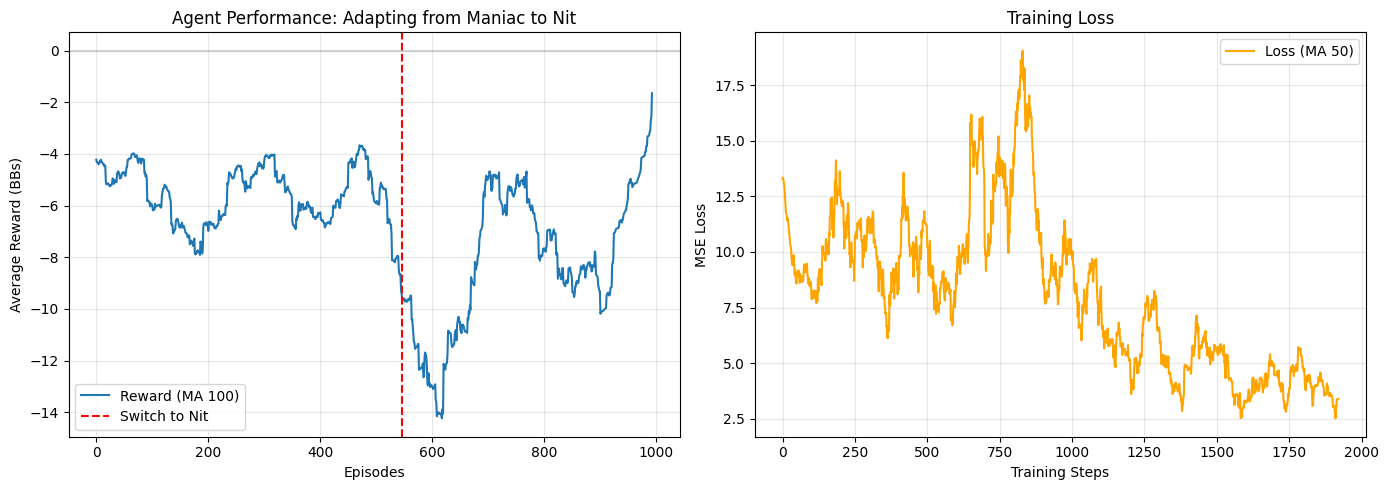

In [11]:
# Cell 11: Visualization

def moving_average(data, window=50):
    if len(data) < window:
        return data
    ret = np.cumsum(data, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

plt.figure(figsize=(14, 5))

# Plot 1: Rewards
plt.subplot(1, 2, 1)
ma_rewards = moving_average(rewards_history, window=100)
plt.plot(ma_rewards, label='Reward (MA 100)')
plt.axvline(x=len(rewards_history)//2, color='r', linestyle='--', label='Switch to Nit')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.title('Agent Performance: Adapting from Maniac to Nit')
plt.xlabel('Episodes')
plt.ylabel('Average Reward (BBs)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss
plt.subplot(1, 2, 2)
if loss_history:
    ma_loss = moving_average(loss_history, window=50)
    plt.plot(ma_loss, label='Loss (MA 50)', color='orange')
    plt.title('Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/tristanpank/repos/poker-bot-test/training_results_v2.png')
print("\nTraining plot saved to training_results_v2.png")
plt.show()

In [12]:
# Cell 12: Final Evaluation

print("\n" + "=" * 60)
print("FINAL EVALUATION")
print("=" * 60)

results = {}
for opp in ['random', 'maniac', 'nit']:
    results[opp] = evaluate_agent(agent, num_hands=200, opponent_type=opp)

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
for opp, r in results.items():
    status = "✓ PASS" if r['avg_reward'] > 0 else "✗ FAIL"
    print(f"{opp.capitalize():10} | Avg: {r['avg_reward']:+.2f} BB/hand | {status}")


FINAL EVALUATION

=== Evaluation vs RANDOM ===
Hands: 200
W/L/T: 2/4/194
Win Rate: 1.0%
Total Profit: -11.0 BBs
Avg Profit/Hand: -0.06 BBs

=== Evaluation vs MANIAC ===
Hands: 200
W/L/T: 0/1/199
Win Rate: 0.0%
Total Profit: -96.0 BBs
Avg Profit/Hand: -0.48 BBs

=== Evaluation vs NIT ===
Hands: 200
W/L/T: 0/0/200
Win Rate: 0.0%
Total Profit: 0.0 BBs
Avg Profit/Hand: 0.00 BBs

SUMMARY
Random     | Avg: -0.06 BB/hand | ✗ FAIL
Maniac     | Avg: -0.48 BB/hand | ✗ FAIL
Nit        | Avg: +0.00 BB/hand | ✗ FAIL
